In [1]:
!pip install torch

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets.folder import default_loader
from torchvision.datasets import VisionDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
print(os.getcwd())
print(os.listdir("data"))

/Users/emanoelagbayani/Desktop/COGS118B
['strawberry', 'potpie', 'pomegranate', 'eggnog', '.DS_Store', 'meatloaf', 'mashedpotato', 'mushroom', 'lemon', 'bagel', 'cucumber', 'jackfruit', 'brocolli', 'burrito', 'hotdog', 'cabbage', 'icecream', '.ipynb_checkpoints', 'banana', 'pizza', 'pineapple', 'pretzel']


In [4]:
print(os)

<module 'os' from '/Users/emanoelagbayani/miniconda3/lib/python3.13/os.py'>


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [6]:
root_dir = "data"
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

num_classes = len(dataset.classes)
print("Detected classes:", dataset.classes)

# ------------------------------
# 3. Train-test split
# ------------------------------
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


Detected classes: ['.ipynb_checkpoints', 'bagel', 'banana', 'brocolli', 'burrito', 'cabbage', 'cucumber', 'eggnog', 'hotdog', 'icecream', 'jackfruit', 'lemon', 'mashedpotato', 'meatloaf', 'mushroom', 'pineapple', 'pizza', 'pomegranate', 'potpie', 'pretzel', 'strawberry']


In [7]:
class FoodCNN(nn.Module):
    def __init__(self, num_classes):
        super(FoodCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            # NEW: Guarantees consistent shape
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),   # = 4096
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = FoodCNN(num_classes)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(dataset.classes)
model = FoodCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
epochs = 10

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):

    # ---------------------------------------
    # TRAINING
    # ---------------------------------------
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---------------------------------------
    # TESTING (THIS is per epoch)
    # ---------------------------------------
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.2f}% | "
        f"Test Acc: {test_acc:.2f}%"
    )

Epoch 1/10 | Train Loss: 2.8359 | Train Acc: 11.48% | Test Acc: 15.97%
Epoch 2/10 | Train Loss: 2.4432 | Train Acc: 20.76% | Test Acc: 23.55%
Epoch 3/10 | Train Loss: 2.2976 | Train Acc: 25.55% | Test Acc: 21.96%
Epoch 4/10 | Train Loss: 2.1668 | Train Acc: 27.79% | Test Acc: 30.34%
Epoch 5/10 | Train Loss: 2.0682 | Train Acc: 32.49% | Test Acc: 29.34%
Epoch 6/10 | Train Loss: 2.0118 | Train Acc: 34.93% | Test Acc: 33.33%
Epoch 7/10 | Train Loss: 1.9543 | Train Acc: 35.68% | Test Acc: 33.13%
Epoch 8/10 | Train Loss: 1.8599 | Train Acc: 39.22% | Test Acc: 34.13%
Epoch 9/10 | Train Loss: 1.7687 | Train Acc: 43.91% | Test Acc: 34.33%
Epoch 10/10 | Train Loss: 1.7359 | Train Acc: 43.86% | Test Acc: 34.13%


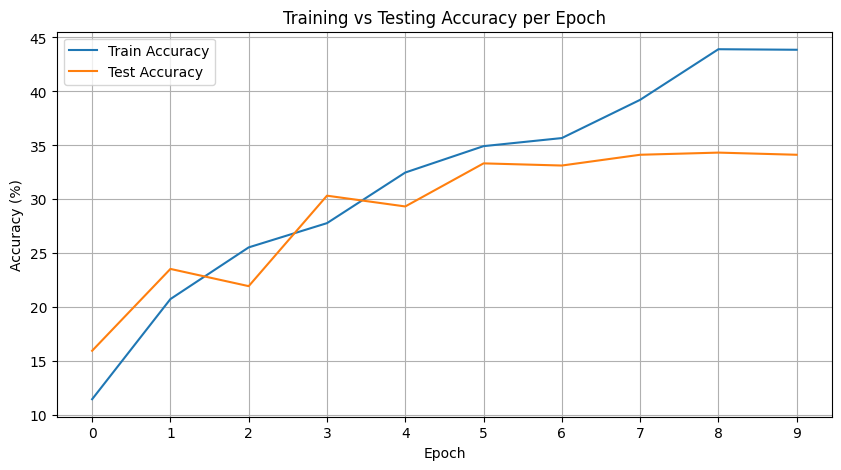

In [10]:
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xticks(range(len(train_accuracies)))  
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Testing Accuracy per Epoch")
plt.grid(True)
plt.show()

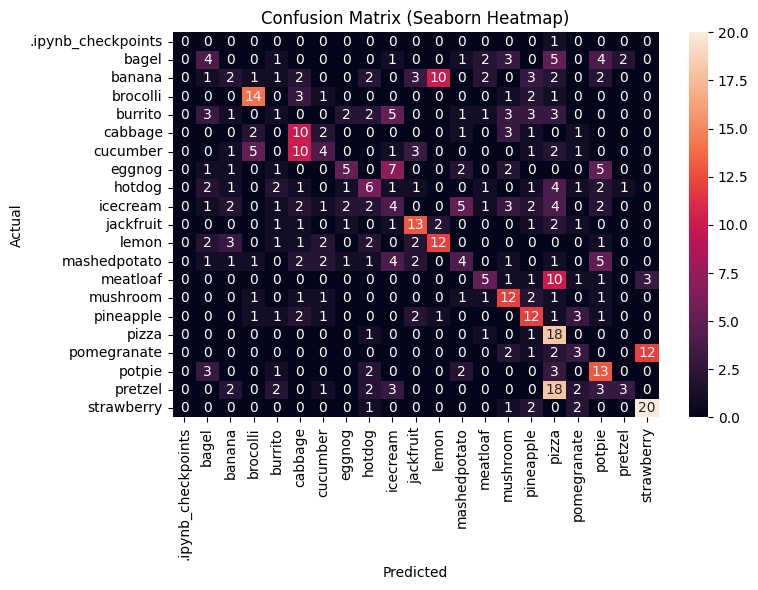

In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
classes = dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm,annot=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Seaborn Heatmap)")
plt.tight_layout()
plt.show()